In [1]:
import os
import sys
scripts_dir = os.path.abspath(os.path.join(os.pardir, "scripts"))
sys.path.append(scripts_dir)
import density_ratio_estimators as dre
import numpy as np
import pandas as pd
import scipy.stats as st
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import get_context
from plotnine import *

In [5]:
def help_do_1_run(numer_class, numer_params, denom_class, denom_params, rng):
    numer_params = numer_params.copy()
    x_numer = numer_class.rvs(**numer_params, random_state=rng)
    size_numer = numer_params.pop("size")
    denom_params = denom_params.copy()
    x_denom = denom_class.rvs(**denom_params, random_state=rng)
    size_denom = denom_params.pop("size")

    x = np.concatenate((x_numer, x_denom))
    f_numer = numer_class.pdf(x, **numer_params)
    f_denom = denom_class.pdf(x, **denom_params)
    r = f_numer / f_denom
    df = pd.DataFrame({"sample_type": np.repeat(["numer", "denom"], [size_numer, size_denom]), "x": x, "r": r})
    return df

def do_1_run(numer_class, numer_params, denom_class, denom_params, estimator_class, estimator_init_args, rng=None):
    df = pd.concat([help_do_1_run(numer_class, numer_params, denom_class, denom_params, rng) for _ in range(2)])
    df.insert(0, "dataset_type", np.repeat(["train", "test"], len(df) // 2))

    df_train = df[df["dataset_type"] == "train"]
    df_test = df[df["dataset_type"] == "test"]

    x_train = df_train["x"].to_numpy().reshape(-1, 1)
    x_train_numer = x_train[df_train["sample_type"] == "numer"]
    x_train_denom = x_train[df_train["sample_type"] == "denom"]
    x_test = df_test["x"].to_numpy().reshape(-1, 1)

    estimator = estimator_class(*estimator_init_args)
    estimator.fit(x_train_numer, x_train_denom)
    r_hat_train = estimator.predict(x_train)
    r_hat_test = estimator.predict(x_test)
    df["r_hat"] = np.concatenate([r_hat_train, r_hat_test])
    df["squared_err"] = (df["r_hat"] - df["r"]) ** 2
    df["rel_err"] = (df["r_hat"] - df["r"]) / df["r"]

    rmse_train = df[df["dataset_type"] == "train"]["squared_err"].mean() ** 0.5
    rmse_test = df[df["dataset_type"] == "test"]["squared_err"].mean() ** 0.5

    return df, rmse_train, rmse_test

def plot_1_run_results(df, rmse_train, rmse_test):
    df = df.copy()
    train_str = f"Training Set (RMSE = {rmse_train:.2f})"
    test_str = f"Test Set (RMSE = {rmse_test:.2f})"
    df["dataset_type"] = np.where(df["dataset_type"] == "train", train_str, test_str)
    plot = (
        ggplot(data=df, mapping=aes(x="x"))
        + facet_wrap("dataset_type")
        + geom_line(mapping=aes(y="r"))
        + geom_line(mapping=aes(y="r_hat"), color="red")
        + labs(y="True or Estimated Ratio", caption="Black line: true ratios, red line: estimates")
        + theme_bw()
    )
    return plot

def simulate(num_runs, max_workers, numer_class, numer_params, denom_class, denom_params, estimator_class, estimator_init_args):
    rng = np.random.default_rng()
    child_rngs = rng.spawn(num_runs)
    rmses = []
    with ProcessPoolExecutor(max_workers, mp_context=get_context("fork")) as executor:
        futures = [
            executor.submit(
                do_1_run, numer_class, numer_params, denom_class, denom_params, estimator_class, estimator_init_args, child_rngs[i]
            )
            for i in range(num_runs)
        ]
        for future in as_completed(futures):
            try:
                _, rmse_train, rmse_test = future.result()
                rmses.append({"rmse_train": rmse_train, "rmse_test": rmse_test})
            except Exception as e:
                print(f"Run failed: {e}")
                rmses.append({"rmse_train": np.nan, "rmse_test": np.nan})
    return pd.DataFrame(rmses)

In [6]:
df, rmse_train, rmse_test = do_1_run(
    numer_class=st.t,
    numer_params={"df": 1, "size": 1000},
    denom_class=st.t,
    denom_params={"df": 2, "size": 10000},
    estimator_class=dre.KNNDensityRatioEstimator,
    estimator_init_args=(300, 3000)
)

/Users/vkverma/research/density_ratio_estimation/env/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1191 rows containing missing values.
/Users/vkverma/research/density_ratio_estimation/env/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1191 rows containing missing values.


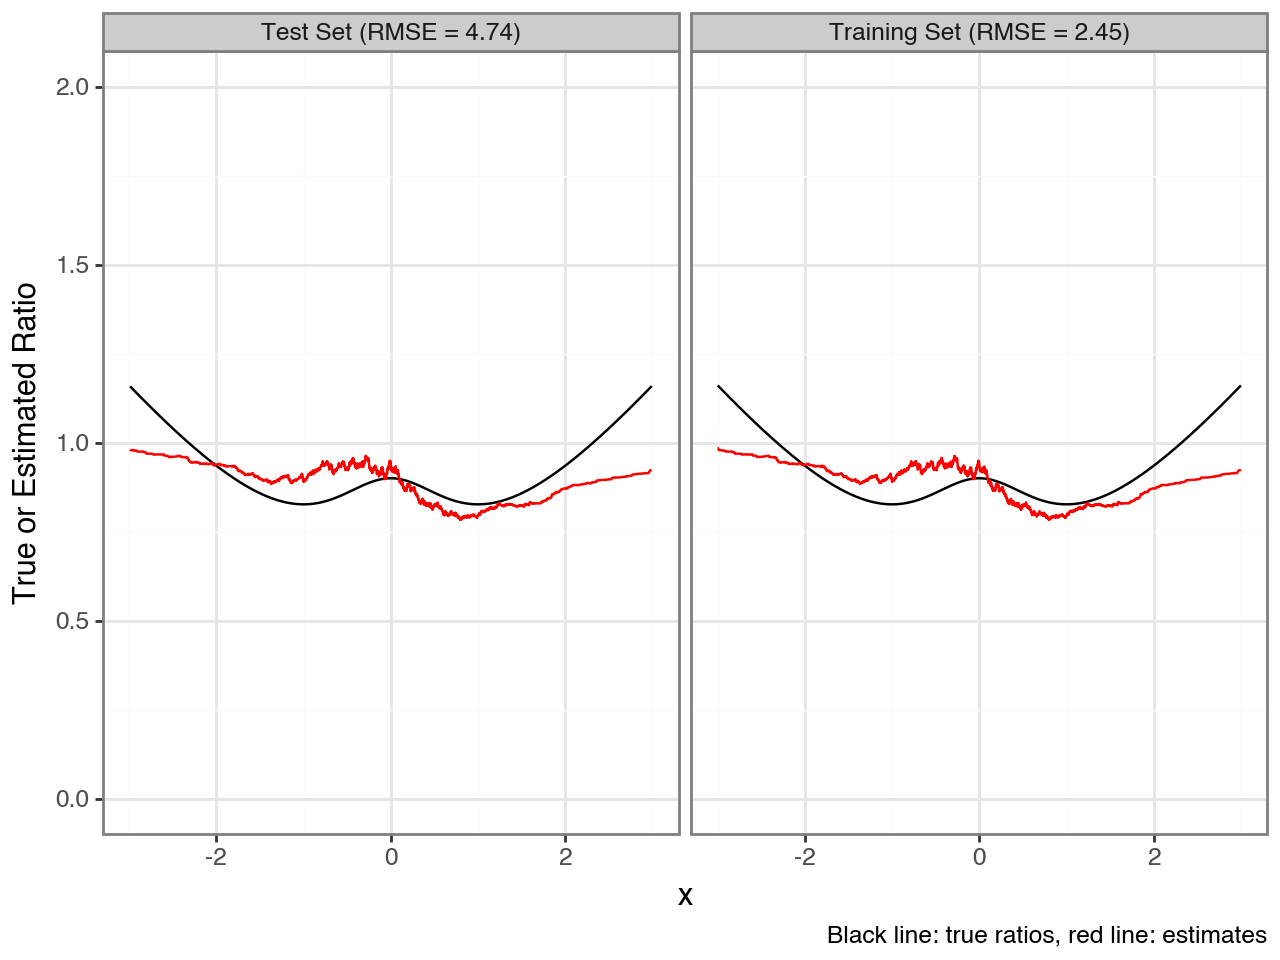

In [7]:
(
    plot_1_run_results(df, rmse_train, rmse_test)
    + xlim((-3, 3))
    + ylim((0, 2))
    #+ scale_y_log10()
)

In [8]:
rmses = simulate(
    num_runs=32,
    max_workers=8,
    numer_class=st.t,
    numer_params={"df": 1, "size": 1000},
    denom_class=st.t,
    denom_params={"df": 2, "size": 10000},
    estimator_class=dre.KNNDensityRatioEstimator,
    estimator_init_args=(300, 3000)
)

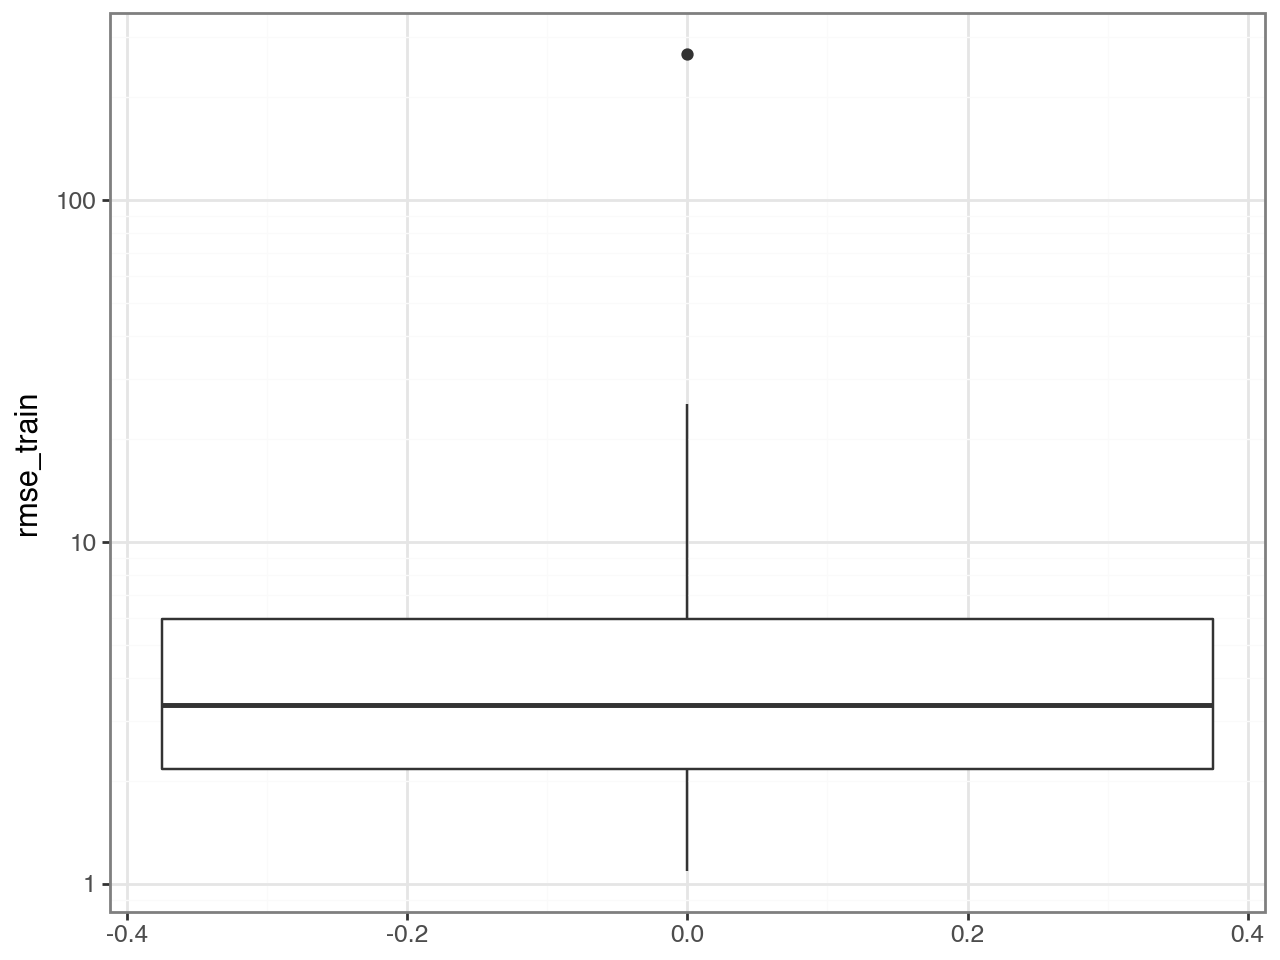

In [9]:
(
    ggplot(data=rmses, mapping=aes(y="rmse_train"))
    + geom_boxplot()
    + scale_y_log10()
    + theme_bw()
)